# Monte Carlo Density Estimation

In [128]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0)

In [129]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset. The Iris data set is used as it is not overly complex.

In [130]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Remove setosa flowers as am only interested in true or false

In [131]:
df = df[df["species"] != "setosa"]
species = df["species"]

Drop species as it is the target.

In [132]:
df = df.drop(["species"], axis=1)

Rename columns as they are annoyingly long.

In [133]:
df.columns = ["s" + str(i) for i, _ in enumerate(df.columns)]

Scale the data (this is essential given the proposed model).
TODO: Change sclaing function to negate sparsity of data, saving the transform function.

In [134]:
df = df.select_dtypes(include=np.number)
scaled = pd.DataFrame(MinMaxScaler().fit_transform(df))
scaled.head()

,0,1,2,3
0,0.700000,0.666667,0.435897,0.266667
1,0.500000,0.666667,0.384615,0.333333
2,0.666667,0.611111,0.487179,0.333333
3,0.200000,0.166667,0.256410,0.200000
4,0.533333,0.444444,0.410256,0.333333


Split into test and train

In [145]:
X_train, X_test, y_train, y_test = train_test_split(scaled, np.array(species), test_size=0.33, random_state=42)

## Classifier Training
and prediction

In [146]:
clf = RandomForestClassifier(n_estimators=16, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [147]:
print(clf.feature_importances_)

[0.09088823 0.0260442  0.38608709 0.49698048]


In [148]:
preds = clf.predict(X_test)
certs = clf.predict_proba(X_test)

In [149]:
confusion = [tn, fp, fn, tp] = confusion_matrix(preds, y_test).ravel()
tn, fp, fn, tp = [i/len(preds) * 100 for i in confusion]
print("Results separated for inspection.")
print("+-------+----------+----------+")
print("|       | Positive | Negative |")
print("+-------+----------+----------+")
print("| True  | {:7.3f}% | {:7.3f}% |".format(tp, tn))
print("+-------+----------+----------+")
print("| False | {:7.3f}% | {:7.3f}% |".format(fp, fn))
print("+-------+----------+----------+")

Results separated for inspection.
+-------+----------+----------+
|       | Positive | Negative |
+-------+----------+----------+
| True  |  33.333% |  57.576% |
+-------+----------+----------+
| False |   9.091% |   0.000% |
+-------+----------+----------+


## Monte Carlo Simulation

The key equation for this estimation of density is:

$$ I = \{ \frac{1}{n} \sum^n_{i=1} f(x_i, \frac{q}{y}) \}^y_{q=0} $$

where 

* $I$ is the dimension the kernel density is being estimated of.

* $n$ is the number of samples taken.

* $f$ is the density function.

* $x$ are randomly selected values from the function, excluding $y$.

* $y$ is the resolution of $I$ (number of samples, equally spaced).

In [195]:
y_column = "s3"  # The dimension to estimate kde of.
y_index = df.columns.get_loc(y_column)  # The index of that dimension.
y_vals = np.linspace(0, 1, y)  # The values of the dimension to estimate density at.
n = 100
y = 11
f = lambda x: clf.predict_proba([x])[0][1]
d = df.shape[1] # Number of dimensions.

In [196]:
I = []
for q in y_vals:
    q_val = []
    for i in range(n):
        # Draw random sample from the sample space.
        D = np.random.uniform(0, 1, d)
        D[y_index] = q

        # Append the density of the prediction at a point.
        prediction = f(D)
        q_val.append(prediction)
    
    q_val = sum(q_val) / n
    I.append(q_val)

I = np.array(I)
I = I - 0.5
print(I)

[-0.13375  -0.168125 -0.143125 -0.188125 -0.03      0.1825    0.2825
  0.3125    0.281875  0.319375  0.3125  ]


In [197]:
bar = pd.DataFrame({"Certainty": I, y_column: np.round(y_vals, 2)})

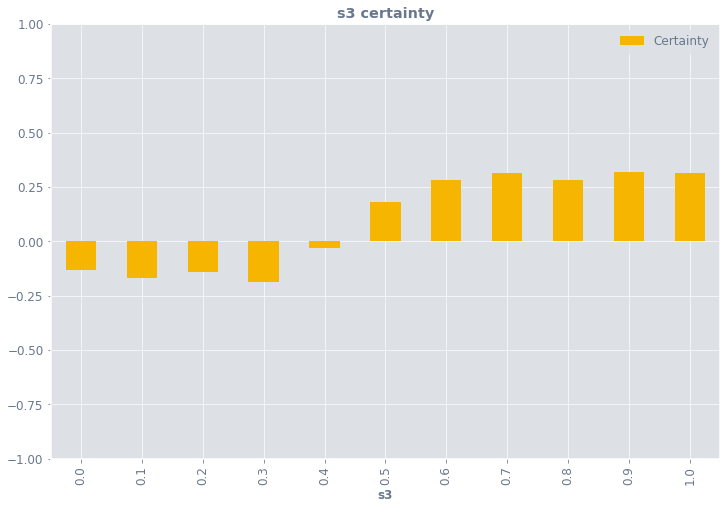

In [198]:
bar.plot.bar(ylim=(-1, 1), x=y_column, title=y_column + " certainty")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127ee9c10>,
      dtype=object)

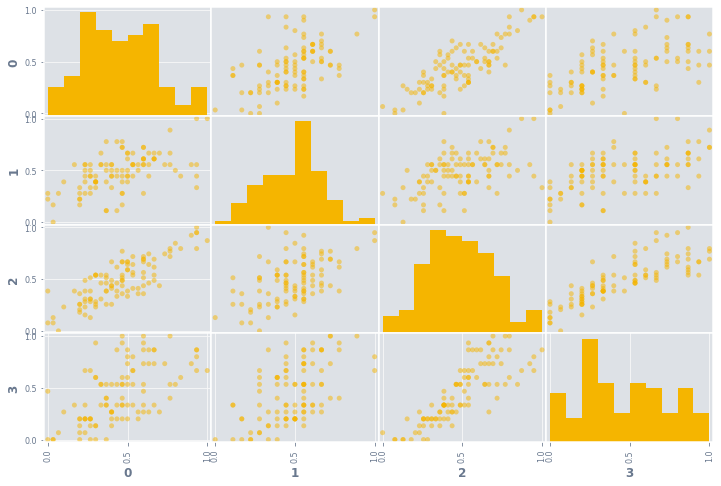

In [154]:
pd.plotting.scatter_matrix(scaled)